Builds a geojson that contains the geometry of voronoi polygons for a given set of points

In [11]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np
import geovoronoi

geovoronoi needs a outer layer to know where to cut of the voronois

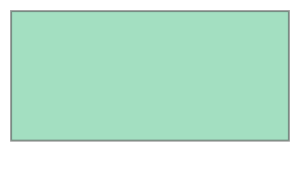

In [12]:
# This layer contains the whole surface of the earth
global_boundary_layer = gpd.read_file("global_boundary.geojson")
global_boundary_layer["geometry"][0]

In [13]:
growth_rate = gpd.GeoDataFrame(pd.read_pickle("seaweed_growth_rate_clustered_global.pkl"))
growth_rate.head()

months_since_war            -3        -2            -1             0    1  \
-78.15209 194.562505  0.000013  0.000010  2.618384e-06  1.169741e-07  0.0   
          195.687505  0.000014  0.000011  4.195485e-06  1.507053e-07  0.0   
          196.812505  0.000015  0.000012  4.946780e-06  1.562531e-07  0.0   
          197.937506  0.000016  0.000012  4.486799e-06  1.141308e-07  0.0   
          320.562509  0.000004  0.000003  2.499075e-07  3.378662e-10  0.0   

months_since_war        2    3             4             5             6  ...  \
-78.15209 194.562505  0.0  0.0  7.807771e-11  4.295335e-08  5.783891e-07  ...   
          195.687505  0.0  0.0  1.120639e-10  5.421054e-08  6.216691e-07  ...   
          196.812505  0.0  0.0  1.409783e-10  5.903569e-08  6.041650e-07  ...   
          197.937506  0.0  0.0  4.002711e-10  6.516756e-08  6.241169e-07  ...   
          320.562509  0.0  0.0  4.658477e-14  2.669136e-12  3.173473e-11  ...   

months_since_war               108  109  110  111           112           113  \
-78.15209 194.562505  2.086107e-08  0.0  0.0  0.0  4.607493e-11  1.071683e-07   
          195.687505  4.104710e-08  0.0  0.0  0.0  1.299792e-10  1.619093e-07   
          196.812505  5.174504e-08  0.0  0.0  0.0  3.325528e-10  1.605867e-07   
          197.937506  4.716973e-08  0.0  0.0  0.0  7.901017e-10  1.814199e-07   
          320.562509  5.009768e-10  0.0  0.0  0.0  3.906038e-12  2.667285e-10   

months_since_war               114           115           116  cluster  
-78.15209 194.562505  1.511997e-06  1.032908e-05  5.656922e-05        1  
          195.687505  1.572849e-06  1.059330e-05  6.410631e-05        1  
          196.812505  1.584246e-06  1.071534e-05  6.976090e-05        1  
          197.937506  1.604507e-06  1.073270e-05  7.320941e-05        1  
          320.562509  2.944176e-09  4.246690e-08  3.493662e-08        1  

[5 rows x 121 columns]

In [14]:
def prepare_geometry(growth_df):
    """
    Prepares the geometry for the growth_df. For some reason the spatial data has
    a longitude that is 0-360 instead of -180 to 180. This function converts it to
    the latter
    Arguments:
        growth_df: a dataframe of the growth rate
    Returns:
        None, but saves the plot
    """
    growth_df["latlon"] = growth_df.index
    growth_df["latitude"] = growth_df["latlon"].str[0]
    growth_df["longitude"] = growth_df["latlon"].str[1]
    growth_df["longitude"] = growth_df["longitude"].apply(
        lambda x: x - 360 if x > 180 else x
    )
    growth_df["geometry"] = (
        growth_df[["longitude", "latitude"]].apply(tuple, axis=1).apply(Point)
    )
    growth_df = gpd.GeoDataFrame(growth_df)
    return growth_df

In [15]:
# Fix the geometry
growth_rate = prepare_geometry(growth_rate)

In [16]:
growth_rate.geometry.head()

-78.15209  194.562505    POINT (-165.43749 -78.15209)
           195.687505    POINT (-164.31249 -78.15209)
           196.812505    POINT (-163.18749 -78.15209)
           197.937506    POINT (-162.06249 -78.15209)
           320.562509     POINT (-39.43749 -78.15209)
Name: geometry, dtype: geometry

Use geovoronoi to calculate the voronoi polygons

In [17]:
region_polys, region_pts = geovoronoi.voronoi_regions_from_coords(growth_rate["geometry"], global_boundary_layer["geometry"][0])

Delete the old geometry from the growth df and attach the voronoi polygons instead. 

In [18]:
del(growth_rate["geometry"])
growth_rate["geometry"] = region_polys.values()

Remove everything else from the df_because we are only intersted in the polygon

In [19]:
growth_rate = growth_rate[["geometry"]].reset_index()

Store it

In [20]:
growth_rate.to_file("voronoi.geojson")